In [1]:
import torch
import torchhd
from torchmetrics import MeanAbsoluteError
import pandas as pd
import seaborn as sns

In [2]:
samples = torchhd.functional.random_hv(3, 512)
levels = torchhd.functional.level_hv(5, 512, randomness=1)
assignments = torch.randint(0, 5, (3,))

In [3]:
targets = levels[assignments]
targets

MAP([[ 1., -1.,  1.,  ...,  1., -1., -1.],
     [ 1., -1.,  1.,  ...,  1., -1., -1.],
     [ 1.,  1.,  1.,  ...,  1.,  1., -1.]])

In [4]:
table = torchhd.functional.hash_table(samples, targets)
table

MAP([-1., -3., -1.,  3., -1., -1.,  1.,  1., -1., -1., -1., -1.,  1., -1.,  1.,
     -1.,  1.,  1., -1.,  3., -3., -1.,  1.,  1.,  3.,  3., -1., -1.,  3.,  1.,
     -1., -1., -1.,  3., -1.,  3., -1., -1.,  1.,  1., -3., -1.,  1., -1., -1.,
      1.,  1.,  1.,  3.,  1., -1.,  3.,  1.,  3., -1.,  1.,  1., -1.,  1.,  3.,
     -1., -1.,  3.,  1.,  3., -1., -1., -3., -1., -1., -3., -1.,  1., -1.,  1.,
     -1.,  3.,  1., -1., -1.,  1., -3., -1.,  1., -3.,  1.,  1.,  1., -1., -3.,
     -1., -1.,  3., -1.,  1., -1.,  3., -1.,  1., -1.,  1.,  3., -1., -1., -1.,
      1., -1.,  3.,  3.,  1., -1.,  3., -3.,  3., -1., -1.,  1., -3.,  3., -1.,
     -1.,  1., -1.,  1.,  1., -3., -1.,  3.,  1., -1.,  3., -1.,  1.,  1., -1.,
      1., -1., -1., -3., -3., -3.,  1., -1.,  1.,  3.,  1., -1.,  1.,  3., -1.,
      1.,  1., -1.,  1., -3.,  1., -3., -1.,  1.,  1., -1.,  1.,  1.,  1.,  3.,
     -3.,  1.,  1.,  1., -1., -1., -1.,  1., -3., -1.,  1.,  1., -1., -3.,  3.,
      1.,  3., -3.,  1.,  1., -1., -3., 

In [5]:
noisy = torchhd.bind(table, torchhd.inverse(samples[0]))
torchhd.cos_similarity(noisy, levels)

MAP([ 0.0484, -0.0507,  0.5736,  0.0253,  0.0161])

In [6]:
targets

MAP([[ 1., -1.,  1.,  ...,  1., -1., -1.],
     [ 1., -1.,  1.,  ...,  1., -1., -1.],
     [ 1.,  1.,  1.,  ...,  1.,  1., -1.]])

In [7]:
assignments

tensor([2, 2, 0])

#### Creating the Toy Data

In [8]:
(torch.rand(10) * 2) - 1

tensor([ 0.4580, -0.9683, -0.2096,  0.3796,  0.2956,  0.7668,  0.0811, -0.4053,
        -0.4567,  0.0940])

In [9]:
def create_toy_data(num_samples, num_dimensions):
    samples = torchhd.functional.random_hv(num_samples, num_dimensions)
    targets = (torch.rand(num_samples) * 2) - 1
    return samples, targets

#### Number of Samples Experimentation

In [10]:
DIMENSIONS = 512
NUM_LEVELS = 100
NUM_TRIALS = 100
num_samples = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

In [11]:
samples, targets = create_toy_data(num_samples[-1], DIMENSIONS)

In [12]:
get_level_hv = torchhd.embeddings.Level(NUM_LEVELS, DIMENSIONS, low=-1, high=1)

In [13]:
t = torch.zeros((3, 10))
t[1, 2] = 5
t

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 5., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [14]:
errors = torch.zeros((NUM_TRIALS, len(num_samples)))
for trial in range(NUM_TRIALS):
    samples, targets = create_toy_data(num_samples[-1], DIMENSIONS)
    levels = get_level_hv(targets)
    for m, n in enumerate(num_samples):
        mae = MeanAbsoluteError()
        memory = torchhd.functional.hash_table(samples[:n], levels[:n])
        for i in range(n):
            s = samples[i]
            l = levels[i]
            l_p = torchhd.bind(memory, torchhd.inverse(s))
            sim = torchhd.cos_similarity(l_p, get_level_hv.weight)
            idx = sim.argmax()
            p = torchhd.functional.map_range(idx.to(torch.float), 0, NUM_LEVELS - 1, -1, 1)
            mae.update(p, targets[i])
        errors[trial, m] = mae.compute()            

In [16]:
errors_df = pd.DataFrame(errors.numpy(), columns=num_samples)
errors_df = errors_df.rename_axis(columns="Number of Samples")
errors_df = pd.melt(errors_df)
errors_df = errors_df.rename(columns={"value": "MAE"})
errors_df

,Number of Samples,MAE
0,1,0.000417
1,1,0.004138
2,1,0.008718
3,1,0.008165
4,1,0.007771
...,...,...
995,512,0.515621
996,512,0.557751
997,512,0.556522
998,512,0.492680


<AxesSubplot: xlabel='Number of Samples', ylabel='MAE'>

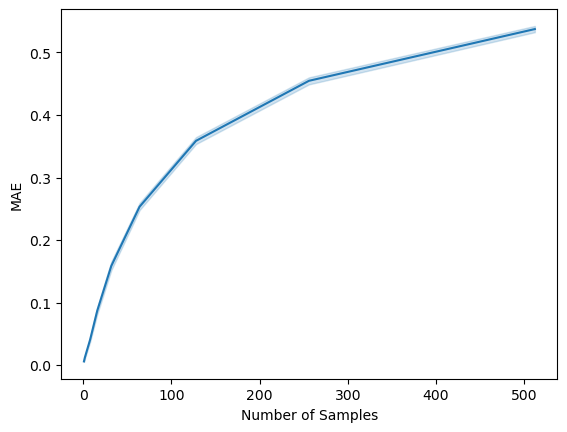

In [17]:
sns.lineplot(data=errors_df, x="Number of Samples", y="MAE")

#### Number of Levels Experimentation

In [18]:
DIMENSIONS = 512
NUM_TRIALS = 100
NUM_SAMPLES = 128
num_levels = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

In [19]:
errors = torch.zeros((NUM_TRIALS, len(num_levels)))
for trial in range(NUM_TRIALS):
    samples, targets = create_toy_data(NUM_SAMPLES, DIMENSIONS)
    for m, n in enumerate(num_levels):
        mae = MeanAbsoluteError()
        get_level_hv = torchhd.embeddings.Level(n, DIMENSIONS, low=-1, high=1)
        levels = get_level_hv(targets)
        memory = torchhd.functional.hash_table(samples, levels)
        for i in range(NUM_SAMPLES):
            s = samples[i]
            l = levels[i]
            l_p = torchhd.bind(memory, torchhd.inverse(s))
            sim = torchhd.cos_similarity(l_p, get_level_hv.weight)
            idx = sim.argmax()
            p = torchhd.functional.map_range(idx.to(torch.float), 0, n - 1, -1, 1)
            mae.update(p, targets[i])
        errors[trial, m] = mae.compute()

In [20]:
errors_df = pd.DataFrame(errors.numpy(), columns=num_levels)
errors_df = errors_df.rename_axis(columns="Number of Levels")
errors_df = pd.melt(errors_df)
errors_df = errors_df.rename(columns={"value": "MAE"})
errors_df

,Number of Levels,MAE
0,2,0.916356
1,2,1.020575
2,2,0.855763
3,2,1.043873
4,2,1.024678
...,...,...
995,1024,8.882533
996,1024,8.501077
997,1024,9.609794
998,1024,8.697655


<AxesSubplot: xlabel='Number of Levels', ylabel='MAE'>

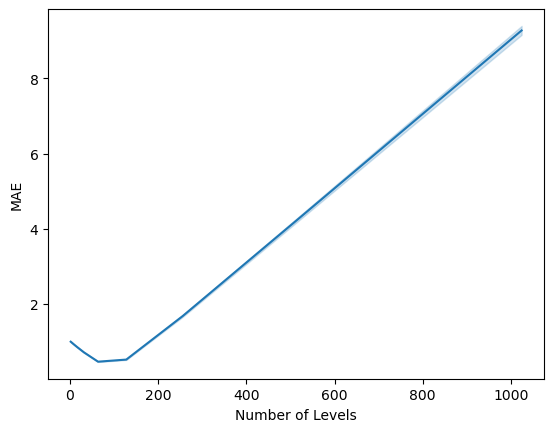

In [21]:
sns.lineplot(data=errors_df, x="Number of Levels", y="MAE")

#### Randomness of Levels Experimentation

In [22]:
DIMENSIONS = 512
NUM_TRIALS = 100
NUM_SAMPLES = 128
NUM_LEVELS = 512
val_randomness = [0, 0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512]

In [23]:
errors = torch.zeros((NUM_TRIALS, len(val_randomness)))
for trial in range(NUM_TRIALS):
    samples, targets = create_toy_data(NUM_SAMPLES, DIMENSIONS)
    for m, n in enumerate(val_randomness):
        mae = MeanAbsoluteError()
        get_level_hv = torchhd.embeddings.Level(NUM_LEVELS, DIMENSIONS, low=-1, high=1, randomness=n)
        levels = get_level_hv(targets)
        memory = torchhd.functional.hash_table(samples, levels)
        for i in range(NUM_SAMPLES):
            s = samples[i]
            l = levels[i]
            l_p = torchhd.bind(memory, torchhd.inverse(s))
            sim = torchhd.cos_similarity(l_p, get_level_hv.weight)
            idx = sim.argmax()
            p = torchhd.functional.map_range(idx.to(torch.float), 0, NUM_LEVELS - 1, -1, 1)
            mae.update(p, targets[i])
        errors[trial, m] = mae.compute()

In [24]:
errors_df = pd.DataFrame(errors.numpy(), columns=val_randomness)
errors_df = errors_df.rename_axis(columns="Randomness")
errors_df = pd.melt(errors_df)
errors_df = errors_df.rename(columns={"value": "MAE"})
errors_df

,Randomness,MAE
0,0.000,0.337468
1,0.000,0.399915
2,0.000,0.368941
3,0.000,0.329138
4,0.000,0.377094
...,...,...
1095,0.512,0.227123
1096,0.512,0.255789
1097,0.512,0.263291
1098,0.512,0.242266


<AxesSubplot: xlabel='Randomness', ylabel='MAE'>

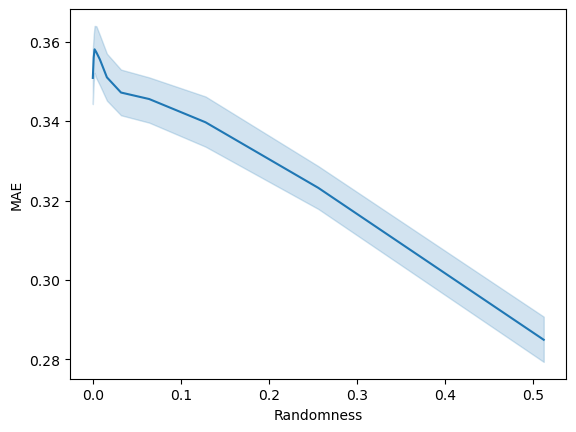

In [25]:
sns.lineplot(data=errors_df, x="Randomness", y="MAE")

#### Number of Samples with Weighted Sum

In [ ]:
DIMENSIONS = 512
NUM_LEVELS = 100
NUM_TRIALS = 100
num_samples = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

In [ ]:
samples, targets = create_toy_data(num_samples[-1], DIMENSIONS)
get_level_hv = torchhd.embeddings.Level(NUM_LEVELS, DIMENSIONS, low=-1, high=1)

In [ ]:
errors = torch.zeros((NUM_TRIALS, len(num_samples)))
for trial in range(NUM_TRIALS):
    samples, targets = create_toy_data(num_samples[-1], DIMENSIONS)
    levels = get_level_hv(targets)
    for m, n in enumerate(num_samples):
        mae = MeanAbsoluteError()
        memory = torchhd.functional.hash_table(samples[:n], levels[:n])
        for i in range(n):
            s = samples[i]
            l = levels[i]
            l_p = torchhd.bind(memory, torchhd.inverse(s))
            sim = torchhd.cos_similarity(l_p, get_level_hv.weight)
            idx = sim.argmax()
            p = torchhd.functional.map_range(idx.to(torch.float), 0, NUM_LEVELS - 1, -1, 1)
            mae.update(p, targets[i])
        errors[trial, m] = mae.compute()

In [ ]:
errors_df = pd.DataFrame(errors.numpy(), columns=num_samples)
errors_df = errors_df.rename_axis(columns="Number of Samples")
errors_df = pd.melt(errors_df)
errors_df = errors_df.rename(columns={"value": "MAE"})
errors_df

In [ ]:
sns.lineplot(data=errors_df, x="Number of Samples", y="MAE")